In [1]:
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
from sklearn import linear_model
import time

In [2]:
def make_noisy(x, std=0.001):
    return x + np.random.normal(size=np.shape(x)) * std

In [10]:
def combine_keypoints_heuristic(point_cloud,
                                n_clusters=12):
    p = np.squeeze(point_cloud)
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=0).fit(p)
    centers = kmeans.cluster_centers_
    c = np.mean(centers, axis=0, keepdims=True)

    xs, ys, zs = np.split(centers, [1, 2], axis=1)
    ransac = linear_model.RANSACRegressor()
    ransac.fit(xs, np.squeeze(ys))

    centers_inlier = centers[ransac.inlier_mask_]
    grasp_point = np.mean(centers_inlier, axis=0, keepdims=True)

    func_point_push = np.mean(
            centers[np.logical_not(ransac.inlier_mask_)],
            axis=0, keepdims=True)

    k = np.squeeze(ransac.estimator_.coef_)
    func_vect_push = np.reshape(
        [1/np.sqrt(1+np.square(k)),
         k/np.sqrt(1+np.square(k)), 0], [1, 3])

    v_cf = func_point_push - c
    if np.dot(
            np.squeeze(v_cf), 
            np.squeeze(func_vect_push)) < 0:
        func_vect_push = -func_vect_push

    func_vect_reach = -func_vect_push
    func_vect_hammer = func_vect_push.dot(
            np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]]))

    vect_grasp_to_centers = (centers - grasp_point) * np.array([1, 1, 0])
    product_reach = np.sum(
            func_vect_reach * vect_grasp_to_centers, axis=1)
    func_point_reach = centers[np.argmax(product_reach)]

    product_hammer = np.sum(
            func_vect_hammer * vect_grasp_to_centers, axis=1)
    func_point_hammer = centers[np.argmax(product_hammer)]

    grasp_point = np.reshape(grasp_point, [1, 3]).astype(np.float32)
    func_point = np.concatenate(
            [np.reshape(func_point_push, [1, 3]),
             np.reshape(func_point_reach, [1, 3]),
             np.reshape(func_point_hammer, [1, 3])], 
            axis=0).astype(np.float32)

    func_vect = np.concatenate(
            [np.reshape(func_vect_push, [1, 3]),
             np.reshape(func_vect_reach, [1, 3]),
             np.reshape(func_vect_hammer, [1, 3])], 
            axis=0).astype(np.float32)

    
    if True:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
        ax.scatter(p[:, 0], p[:, 1], c='green', s=0.1, alpha=0.3)
        ax.scatter(
            func_point[:, 0], func_point[:, 1], c='green', s=10)
        ax.scatter(
            func_point[:, 0] + func_vect[:, 0] * 0.1, func_point[:, 1] + func_vect[:, 1] * 0.1, c='green', s=10)
        ax.scatter(
            grasp_point[0, 0], grasp_point[0, 1], c='red', s=10)
        plt.xlim((0.3, 1.0))
        plt.ylim((-0.5, 0.1))
        plt.show()


In [19]:
point_cloud = np.load(open('../../episodes/combine_point_cloud/point_cloud/417938_000000.npy', 'rb'))

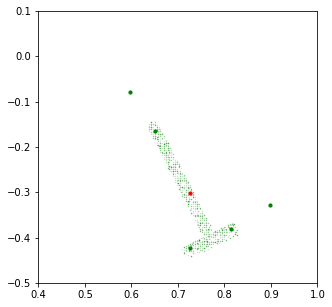

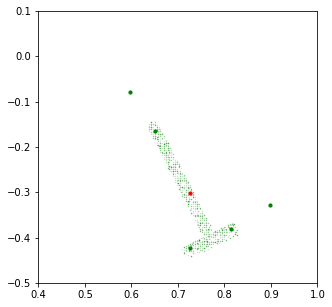

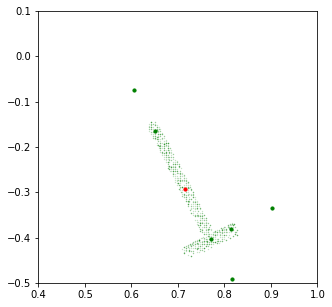

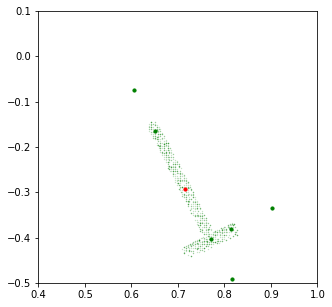

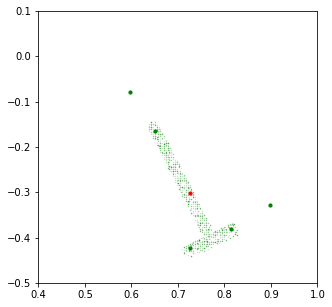

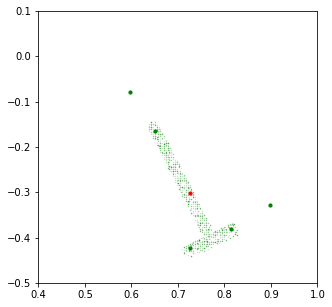

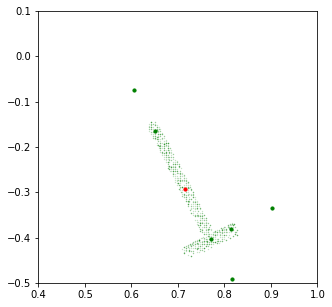

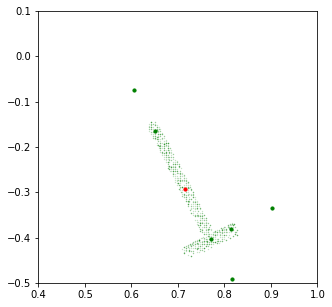

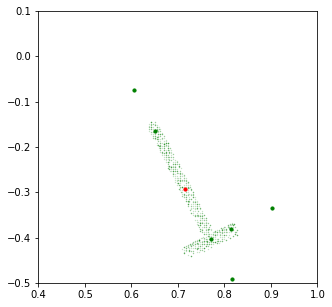

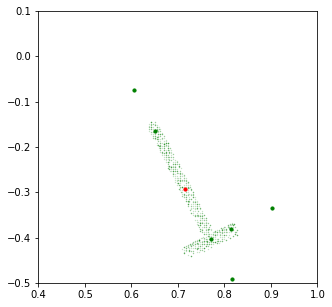

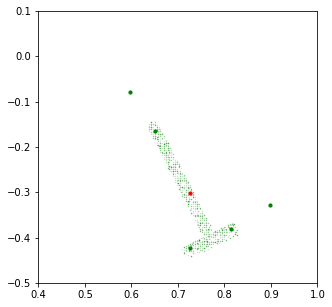

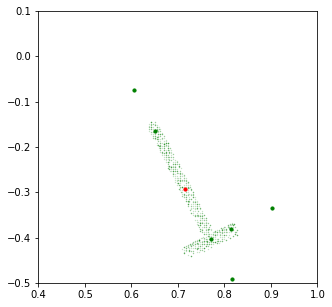

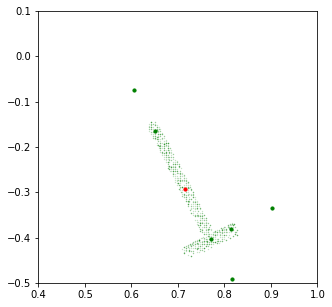

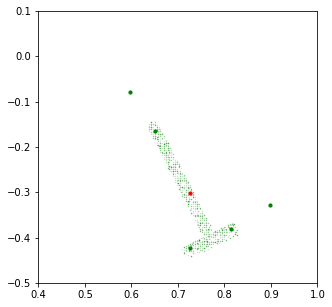

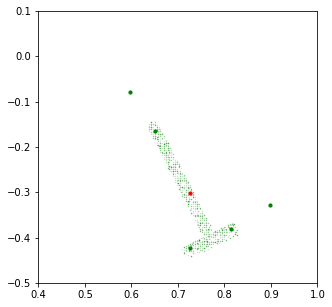

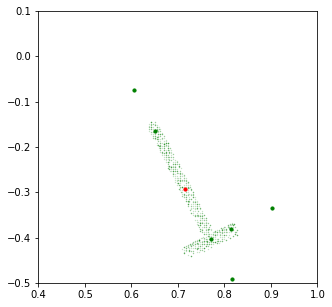

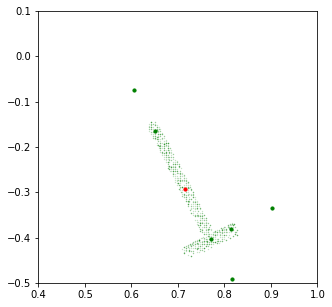

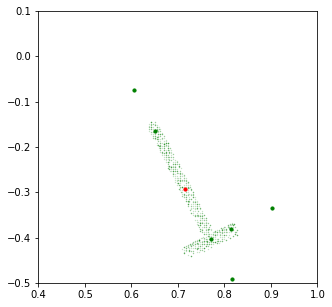

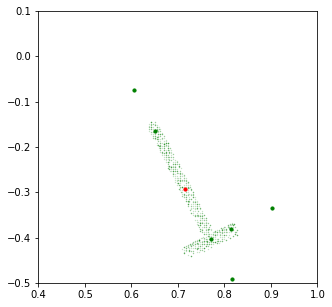

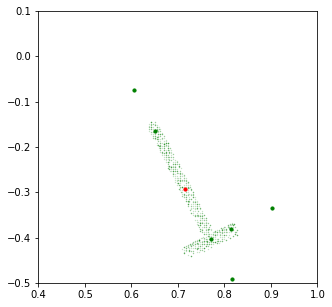

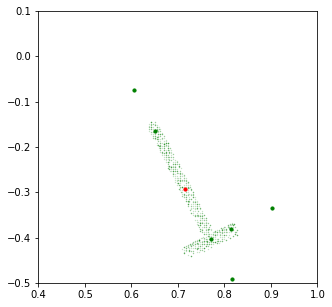

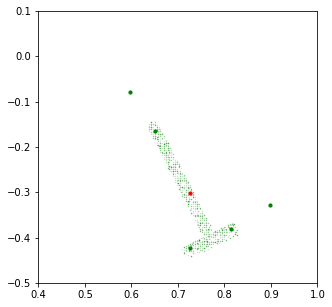

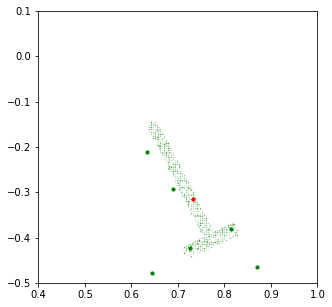

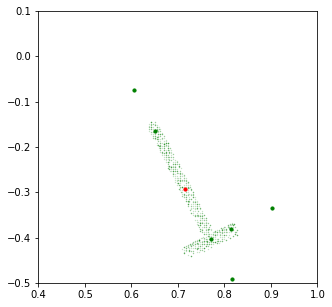

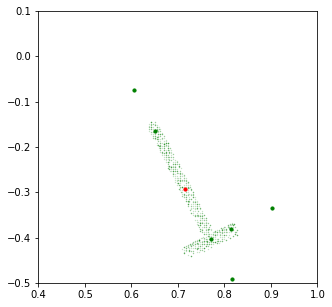

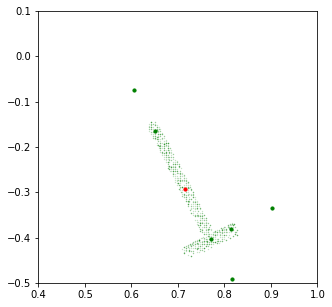

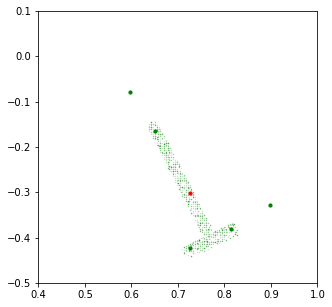

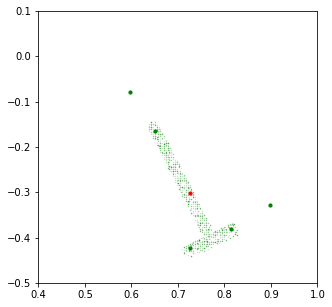

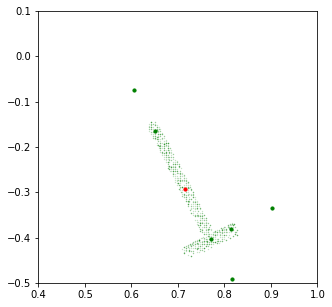

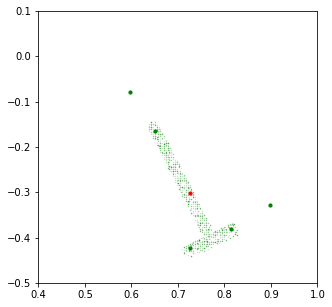

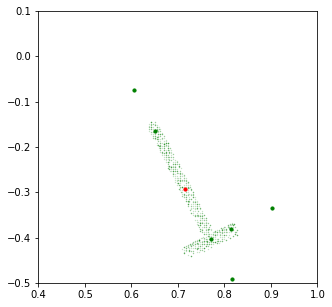

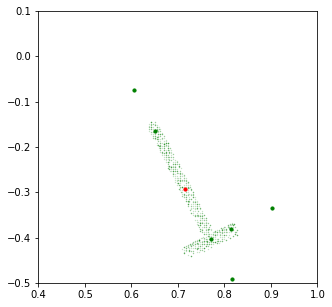

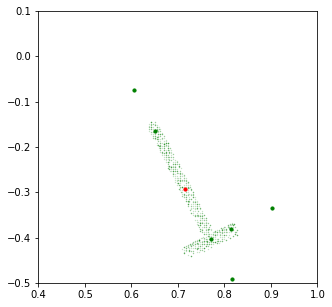

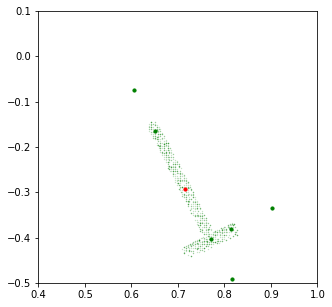

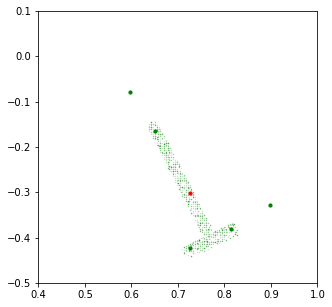

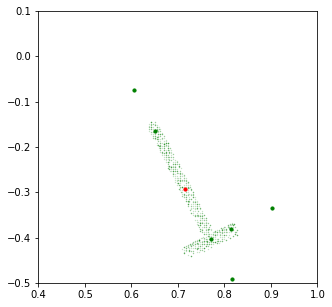

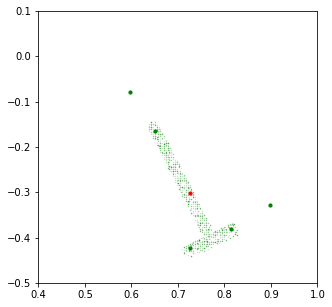

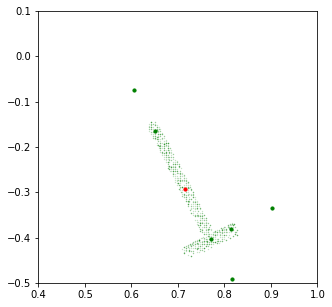

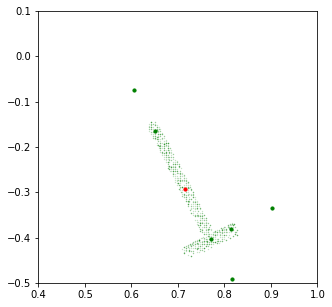

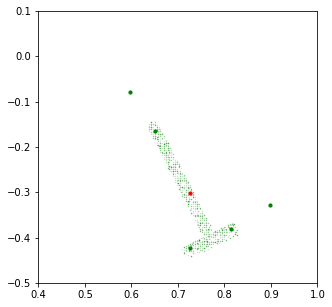

0.28967695236206054


In [20]:
start = time.time()
for _ in range(40):
    combine_keypoints_heuristic(point_cloud)
    
end = time.time()
print((end-start)/40)